# Gymnasium Environment

This notebook showcases the integration of navground in gymnasium environments.

To start, let us load one of navground benchmark scenarios

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
%%writefile scenario.yaml
type: Cross
agent_margin: 0.1
side: 4
target_margin: 0.1
tolerance: 0.5
groups:
  -
    type: thymio
    number: 20
    radius: 0.1
    control_period: 0.1
    speed_tolerance: 0.02
    color: gray
    kinematics:
      type: 2WDiff
      wheel_axis: 0.094
      max_speed: 0.12
    behavior:
      type: HL
      optimal_speed: 0.12
      horizon: 5.0
      tau: 0.25
      eta: 0.5
      safety_margin: 0.1
    state_estimation:
      type: Bounded
      range: 5.0

Overwriting scenario.yaml


In [3]:
from navground import sim

with open('scenario.yaml') as f:
    scenario = sim.load_scenario(f.read())

where 20 agents moves between two pairs of waypoints, crossing in the middle.

In [4]:
from navground.sim.ui.video import display_video

world = scenario.make_world()
display_video(world, time_step=0.1, duration=100, factor=10, display_width=400)

We want setup an gymnasium environment where one of these agents uses a ML policy to navigate using a sensor.
We select an high-level sensor that computes the 5 nearest neighbors and returns them as arrays of positions, velocities and radii.

In [5]:
%%writefile sensor.yaml
type: Discs
number: 5
range: 5.0
max_speed: 0.12
max_radius: 0.1

Overwriting sensor.yaml


In [6]:
with open('sensor.yaml') as f:
    sensor = sim.load_state_estimation(f.read())

In [7]:
from navground.learning import DefaultObservationConfig, ControlActionConfig

observation_config = DefaultObservationConfig(include_target_direction=True, include_target_distance=True)
action_config = ControlActionConfig()
observation_config, action_config

(DefaultObservationConfig(), ControlActionConfig())

In [8]:
import gymnasium as gym
from navground.learning.rewards import SocialReward

env = gym.make('navground.learning.env:navground',
               scenario=scenario,
               sensor=sensor,
               action=action_config,
               observation=observation_config,
               reward=SocialReward(),
               time_step=0.1,
               max_episode_steps=600)

When we import the enviroment implicly, as we have just done by importing the reward, or explictly, e.g., with `import navground.learning.env`, we can shorten the reference to just its name

In [9]:
env = gym.make('navground',
               scenario=scenario,
               sensor=sensor,
               action=action_config,
               observation=observation_config,
               reward=SocialReward(),
               time_step=0.1,
               max_episode_steps=600)

Let's check its observation and action spaces.

The action space 

In [10]:
env.action_space

Box(-1.0, 1.0, (2,), float32)

is composed of linear and angular speeds (normalized by their maximal values)

In [11]:
env.unwrapped.action_config.max_speed, env.unwrapped.action_config.max_angular_speed

(0.11999999731779099, 2.5531914234161377)

which in this case have been inherited from the scenario specifications but could have been set explicitly in `ControlActionConfig`

The observation space 

In [12]:
env.observation_space

Dict('position': Box(-5.0, 5.0, (5, 2), float32), 'radius': Box(0.0, 0.1, (5,), float32), 'valid': Box(0, 1, (5,), uint8), 'velocity': Box(-0.12, 0.12, (5, 2), float32), 'ego_target_direction': Box(-1.0, 1.0, (2,), float32), 'ego_target_distance': Box(0.0, inf, (1,), float32))

is composed of the agent own state (`ego_...`) and the reading from the sensor, in this case `position`, `radius` and `velocity` of the 5 nearest neighbors, coherently with the sensor's description

In [13]:
sensor.description

{'position': BufferDescription(shape=(5, 2), type=dtype('float32'), low=-5.0, high=5.0, categorical=False),
 'radius': BufferDescription(shape=(5,), type=dtype('float32'), low=0.0, high=0.10000000149011612, categorical=False),
 'valid': BufferDescription(shape=(5,), type=dtype('uint8'), low=0.0, high=1.0, categorical=False),
 'velocity': BufferDescription(shape=(5, 2), type=dtype('float32'), low=-0.11999999731779099, high=0.11999999731779099, categorical=False)}

The `info` map returned by `env.reset(...)` and `env.step(...)` contains the action computed by original navground behavior, in this case `HL`:

In [14]:
observation, info = env.reset()
print(f"Observation: {observation}")
print(f"Info {info}")

Observation: {'ego_target_distance': array([1.3484901], dtype=float32), 'ego_target_direction': array([ 1.0000000e+00, -1.5725663e-08], dtype=float32), 'position': array([[-0.00738173, -0.30817246],
       [-0.38925827,  0.01894906],
       [-0.46368217, -0.4778133 ],
       [ 0.15306982, -0.6674728 ],
       [ 0.5088892 , -0.62434775]], dtype=float32), 'radius': array([0.1, 0.1, 0.1, 0.1, 0.1], dtype=float32), 'valid': array([1, 1, 1, 1, 1], dtype=uint8), 'velocity': array([[0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.]], dtype=float32)}
Info {'navground_action': array([0.32967997, 0.        ], dtype=float32)}


which we can use to define a policy that simply ask the agent to actuate the action that it has already computed. 

Let us collect the reward from the navground policy in this way. 
To understand the scale, in this case, the reward assigned at each step in maximal (=0) when the agents move straight towards the goal at optimal speed. When the entire safety margin is violated, it gets a penality of at most -1, the same value it gets if it stay in-place, while moving in the opposite target direction at optimal speed gets a -2. Therefore, we can expect an average reward between -1 and 0, and possibly near to 0 for a well-performing navigation behavior.

In [15]:
import numpy as np

rewards = []
for n in range(1000):
    action = info['navground_action']
    observation, reward, terminated, truncated, info = env.step(action)
    rewards.append(reward)
    if terminated or truncated:
        print(f'reset after {n} steps')
        observation, info = env.reset()

print(f'mean reward {np.mean(rewards):.3f}')

reset after 599 steps
mean reward -0.289


We compare it (just for fun) with the reward from a random policy, which we expect to be around -1, as an average between of moving towards the target (=0) and away of the target (-2).

In [16]:
observation, info = env.reset()
rewards = []
for n in range(1000):
    action = env.action_space.sample()
    observation, reward, terminated, truncated, info = env.step(action)
    rewards.append(reward)
    if terminated or truncated:
        print(f'reset after {n} steps')
        observation, info = env.reset()

print(f'mean reward {np.mean(rewards):.3f}')

reset after 599 steps
mean reward -0.912


In general, we want to use a policy to generate the action, i.e. a function that maps observations to actions.
In this case, let us try again with a *random* policy

In [17]:
from navground.learning.policies.random_policy import RandomPolicy

policy = RandomPolicy(observation_space=env.observation_space, action_space=env.action_space)

We export this policy to ONNX for later use in the [Behavior](Behavior.ipynb) notebook.

In [18]:
import warnings
from navground.learning import onnx

with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    onnx.export(policy, "policy.onnx")

Policies that follow the [StableBaseline3 API](https://stable-baselines3.readthedocs.io/en/master), like this one, 
output a tuple `(action, state)`. Therefore the loop become

In [19]:
observation, info = env.reset()
rewards = []
for n in range(1000):
    action, state = policy.predict(observation)
    observation, reward, terminated, truncated, info = env.step(action)
    rewards.append(reward)
    if terminated or truncated:
        print(f'reset after {n} steps')
        observation, info = env.reset()

print(f'mean reward {np.mean(rewards):.3f}')

reset after 599 steps
mean reward -0.984


### Navground policy

The enviroment exposes a special policy that extracts the action from the info dictionary (i.e.,  the same job we have done manually above).

In [20]:
policy = env.unwrapped.policy

While policies used for inference in general conform to a protocol like

```python
class PolicyPredictor(Protocol):

    def predict(self,
                observation: Observation,
                state: State | None = None,
                episode_start: EpisodeStart | None = None,
                deterministic: bool = False) -> tuple[Action, State | None]:
        ...
```

`navground.learning` supports policies that accept the info dictionary, which we how navground exposes its through to Gymnasium.

```python
class PolicyPredictorWithInfo(Protocol):

    def predict(self,
                observation: Observation,
                state: State | None = None,
                episode_start: EpisodeStart | None = None,
                deterministic: bool = False,
                info: Info | None = None) -> tuple[Action, State | None]:
        ...
```


In [21]:
observation, info = env.reset()
rewards = []
for n in range(1000):
    action, state = policy.predict(observation, info=info)
    observation, reward, terminated, truncated, info = env.step(action)
    rewards.append(reward)
    if terminated or truncated:
        print(f'reset after {n} steps')
        observation, info = env.reset()

print(f'mean reward {np.mean(rewards):.3f}')

reset after 599 steps
mean reward -0.237


## Wrappers

One common way to add functionality to Gymansium enviroments is to [wrap](https://gymnasium.farama.org/api/wrappers/) them.

For instance, we can use wrappers to

- auto-reset the enviroment when the episode finishes
- record statistics about episodes (length, cumulated rewards, ...)

to automatically gather similar data as before:

In [22]:
from gymnasium.wrappers import RecordEpisodeStatistics, Autoreset

r_env = RecordEpisodeStatistics(env)
a_env = Autoreset(r_env)
_, info = a_env.reset(seed=0)
while r_env.episode_count < 10:
    *_, info = a_env.step(info['navground_action'])

episode_mean_reward = [cum_reward / n for n, cum_reward in zip(r_env.length_queue, r_env.return_queue)]
print(f'mean reward of {r_env.episode_count} episodes: {np.mean(episode_mean_reward):.3f}')

mean reward of 10 episodes: -0.249


## Rendering

Gymansium environments API covers rendering the state of the process, which in our case, is the state of the simulated world. [NavgroundEnv](../../reference/env.html#navground.learning.env.NavgroundEnv) supports rendering in real-time (with `render_mode="human"`) or offline (with `render_mode="rgb_array"`).

We can even render online inside a jupyter notebook.

In [23]:
import nest_asyncio
from navground.sim.notebook import notebook_view
from navground.sim.ui.to_html import open_html

# This is only required to run render_mode="human" in a notebook
nest_asyncio.apply()

In [24]:
# To open a new browser windows with the view
open_html(640, port=8002)

In [25]:
# To display in the notebook direclty
# notebook_view(width=300, port=8002)

In [26]:
rt_env = gym.make('navground',
                  scenario=scenario,
                  sensor=sensor,
                  action=action_config,
                  observation=observation_config,
                  reward=SocialReward(),
                  time_step=0.1,
                  max_duration=60.0,
                  render_mode="human",
                  realtime_factor=10.0)

In [27]:
observation, info = rt_env.reset()
for n in range(750):
    action = info['navground_action']
    observation, reward, terminated, truncated, info = rt_env.step(action)
    if terminated or truncated:
        observation, info = rt_env.reset()
rt_env.close()

To render offline, we call `render()`

In [28]:
from PIL import Image
from IPython.display import display

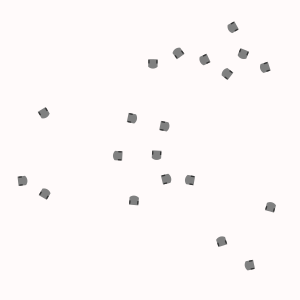

In [29]:
env = gym.make('navground',
                scenario=scenario,
                sensor=sensor,
                action=action_config,
                observation=observation_config,
                reward=SocialReward(),
                time_step=0.1,
                render_mode="rgb_array",
                render_kwargs = {'width': 300},
                max_episode_steps=600)
env.reset()
image = Image.fromarray(env.render())
# image.show()
image = image.resize((image.width, image.height))
display(image)

We can also render a video

In [30]:
from gymnasium.wrappers import RecordVideo

video_env = RecordVideo(
    env, video_folder=".", name_prefix="gym",
    episode_trigger=lambda x: True,
    disable_logger=True)

# 10 x
video_env.metadata['render_fps'] = 300

obs, info = video_env.reset()
done = False
while not done:
    action = env.action_space.sample()  # replace with actual agent
    obs, reward, terminated, truncated, info = video_env.step(action)
    done = terminated or truncated
video_env.close()

In [31]:
from IPython.display import Video

Video("gym-episode-0.mp4", width=300)

## Saving and loading

Navground uses YAML to represent different types of objects, like we have seen when loading a scenario and a sensor from a YAML file. So, it should not be a surprise that we can represent an environment to YAML to save and the load it. Let us export the one we are using to `env.yaml` 

In [32]:
from navground.learning import io

io.save_env(env, path='env.yaml')

The YAML file contains all the information we need to recreate the environment.

In [33]:
from IPython.display import Code

Code(filename='env.yaml', language='yaml')

groups:
- action:
    dof: null
    dtype: ''
    fix_orientation: false
    has_wheels: null
    max_acceleration: .inf
    max_angular_acceleration: .inf
    max_angular_speed: .inf
    max_speed: .inf
    type: Control
    use_acceleration_action: false
    use_wheels: false
  indices:
    type: set
    values:
    - 0
  observation:
    dof: null
    dtype: ''
    flat: false
    history: 1
    include_angular_speed: false
    include_radius: false
    include_target_angular_speed: false
    include_target_direction: true
    include_target_direction_validity: false
    include_target_distance: true
    include_target_distance_validity: false
    include_target_speed: false
    include_velocity: false
    max_angular_speed: .inf
    max_radius: .inf
    max_speed: .inf
    max_target_distance: .inf
    type: Default
  reward:
    alpha: 0.0
    beta: 1.0
    critical_safety_margin: 0.0
    default_social_margin: 0.0
    safety_margin: null
    social_margins: {}
    type: Social
  sensor:
    include_valid: true
    max_id: 0
    max_radius: 0.100000001
    max_speed: 0.119999997
    name: ''
    number: 5
    range: 5
    type: Discs
    use_nearest_point: true
max_duration: -1.0
realtime_factor: 1.0
render_kwargs:
  width: 300
render_mode: rgb_array
scenario:
  add_safety_to_agent_margin: true
  agent_margin: 0.100000001
  groups:
  - behavior:
      eta: 0.5
      horizon: 5
      optimal_speed: 0.119999997
      safety_margin: 0.100000001
      tau: 0.25
      type: HL
    color: gray
    control_period: 0.100000001
    kinematics:
      max_speed: 0.119999997
      type: 2WDiff
      wheel_axis: 0.0939999968
    number: 20
    radius: 0.100000001
    speed_tolerance: 0.0199999996
    state_estimation:
      range: 5
      type: Bounded
    type: thymio
  obstacles: []
  side: 4
  target_margin: 0.100000001
  tolerance: 0.5
  type: Cross
stuck_timeout: 1
terminate_outside_bounds: false
time_step: 0.1
type: NavgroundEnv

The YAML representation is shared with the parallel multi-agent environment that we are going to discuss in the next notebook, which explain why there is a `"groups"` field when we are controlling a single agent.

We can reload the environment with:

In [34]:
env1 = io.load_env('env.yaml')

## Vectorized environments

[NavgroundEnv](../../reference/env.html#navground.learning.env.NavgroundEnv) supports [vectorizing](https://gymnasium.farama.org/api/vector/) the environment. 

In [35]:
venv = gym.make_vec("navground.learning.env:navground", num_envs=2,
                    scenario=scenario,
                    sensor=sensor,
                    action=action_config,
                    observation=observation_config,
                    reward=SocialReward(),
                    time_step=0.1,
                    render_mode="rgb_array")

In [36]:
venv.num_envs

2

Gymansium vectorized environements exposes the same API as normal environments. 
As expected, observation and action spaces are vectorized (i.e., with an additional axis of size `num_envs`)

In [37]:
print(f'Vectorized observation space: {venv.observation_space}')
print(f'Vectorized action space: {venv.action_space}')

Vectorized observation space: Dict('ego_target_direction': Box(-1.0, 1.0, (2, 2), float32), 'ego_target_distance': Box(0.0, inf, (2, 1), float32), 'position': Box(-5.0, 5.0, (2, 5, 2), float32), 'radius': Box(0.0, 0.1, (2, 5), float32), 'valid': Box(0, 1, (2, 5), uint8), 'velocity': Box(-0.12, 0.12, (2, 5, 2), float32))
Vectorized action space: Box(-1.0, 1.0, (2, 2), float32)


In [38]:
observation, info = venv.reset(seed=1)

Once seeded, the environments contains different worlds

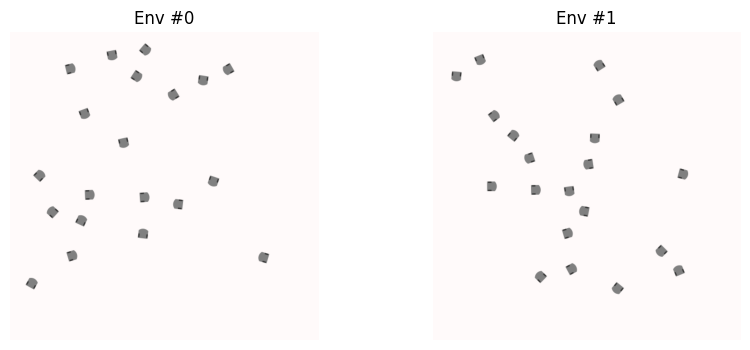

In [39]:
from matplotlib import pyplot as plt
images = venv.call("render")
fig, axs = plt.subplots(ncols=len(images), figsize=(10, 4))

for i, (ax, im) in enumerate(zip(axs, images)):
    # im = im.astype(float)/255
    im = im.astype('short')
    ax.imshow(im)
    ax.axis('off')
    ax.set_title(f"Env #{i}")

and can be simulated with the same loop, where we don't need to manually reset individual envs, as the vectorized env autoreset them.

In [40]:
all_rewards = []
for n in range(1000):
    # original navground actions
    # actions = info['navground_action']
    # or random actions
    actions = venv.action_space.sample()
    observations, rewards, terminated, truncated, info = venv.step(actions)
    all_rewards.append(rewards)

all_rewards = np.array(all_rewards)
print(f'mean reward {np.mean(all_rewards, axis=0)}')

mean reward [-1.03823532 -0.96512122]


There are other types of vectorized environments that exposes a slightly different API.
For instance, the vectorized environments of 
[Stable-Baselines3](https://stable-baselines3.readthedocs.io/en/master/guide/vec_envs.html)
follow an older version of the Gym API, which has several [differences](https://stable-baselines3.readthedocs.io/en/master/guide/vec_envs.html#vecenv-api-vs-gym-api) with respect to basics environments.

In [41]:
from stable_baselines3.common.env_util import make_vec_env

venv = make_vec_env(
    "navground", n_envs=2, seed=1,
     env_kwargs={
         'scenario': scenario,
         'sensor': sensor,
         'action': action_config,
         'observation': observation_config,
         'time_step': 0.1,
         'reward': SocialReward(),
         'render_mode': "rgb_array",
         'render_kwargs': {'width': 300},
     })

# use 
# venv = make_vec_env(lambda: gym.make(env.spec), n_envs=4)
# to vectorized an already defined env

In this case, actions and observations are *not* vectorized

In [42]:
print(f'Observation space: {venv.observation_space}')
print(f'Action space: {venv.action_space}')

Observation space: Dict('position': Box(-5.0, 5.0, (5, 2), float32), 'radius': Box(0.0, 0.1, (5,), float32), 'valid': Box(0, 1, (5,), uint8), 'velocity': Box(-0.12, 0.12, (5, 2), float32), 'ego_target_direction': Box(-1.0, 1.0, (2,), float32), 'ego_target_distance': Box(0.0, inf, (1,), float32))
Action space: Box(-1.0, 1.0, (2,), float32)


and we need to use a slightly different API

In [43]:
observation = venv.reset()
info = venv.reset_infos

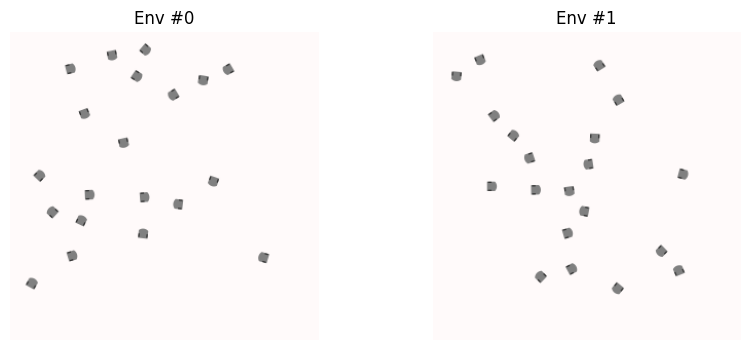

In [44]:
from matplotlib import pyplot as plt
images = venv.get_images()
fig, axs = plt.subplots(ncols=len(images), figsize=(10, 4))

for i, (ax, im) in enumerate(zip(axs, images)):
    ax.imshow(im)
    ax.axis('off')
    ax.set_title(f"Env #{i}")

to get run the same cycle

In [45]:
all_rewards = []
for n in range(1000):
    # actions = [i['navground_action'] for i in info]
    actions = [venv.action_space.sample() for _ in range(venv.num_envs)]
    observations, rewards, done, info = venv.step(actions)
    all_rewards.append(rewards)

all_rewards = np.array(all_rewards)
print(f'mean reward {np.mean(all_rewards, axis=0)}')

mean reward [-1.000946  -1.2025803]
